In [ ]:
import torch
import torchvision.models as models
import cv2
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random


## Chech the model Architecture

In [14]:
print("Loading VGG16 model...")
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

print("\nVGG16 Architecture")
print(model)

Loading VGG16 model...

VGG16 Architecture
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(ker

## Choosing the best layer

In [ ]:
IMG_SIZE = 224 # VGG expects 224x224 images

LAYERS_TO_INSPECT = {
    'conv1_2': 2,
    'conv2_2': 7,
    'conv3_2': 12,
    'conv4_2': 19,
    'conv5_2': 26
} 

In [ ]:
def get_features_at_layer(model, layer_index, preprocessed_frame):
    """Gets the feature map from a specific layer."""
    truncated_model = torch.nn.Sequential(*list(model.features.children())[:layer_index + 1])
    with torch.no_grad():
        features = truncated_model(preprocessed_frame)
    return features.squeeze(0)

In [3]:
def preprocess_image(frame):
    """Converts a CV2 frame to a normalized PyTorch tensor."""
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    return transform(frame).unsqueeze(0)

In [ ]:
def plot_channel_grid(feature_map, layer_name):    
    num_channels = feature_map.shape[0]
    random_indices = random.sample(range(num_channels), 8)
    
    fig, axes = plt.subplots(2, 4, figsize=(10, 6))
    
    for i, ax in enumerate(axes.flat):
        channel_idx = random_indices[i]
        channel_map = feature_map[channel_idx].numpy()
        norm_map = cv2.normalize(channel_map, None, 0, 1, cv2.NORM_MINMAX)
        
        large_map = cv2.resize(norm_map, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        
        ax.imshow(large_map, cmap='gray')
        ax.set_title(f"Channel {channel_idx}")
        ax.axis('off')

    plt.suptitle(f"Layer: '{layer_name}'", fontsize=20)
    plt.tight_layout()
    plt.show()

In [10]:
model.eval()
print("Model ready.")

Model ready.


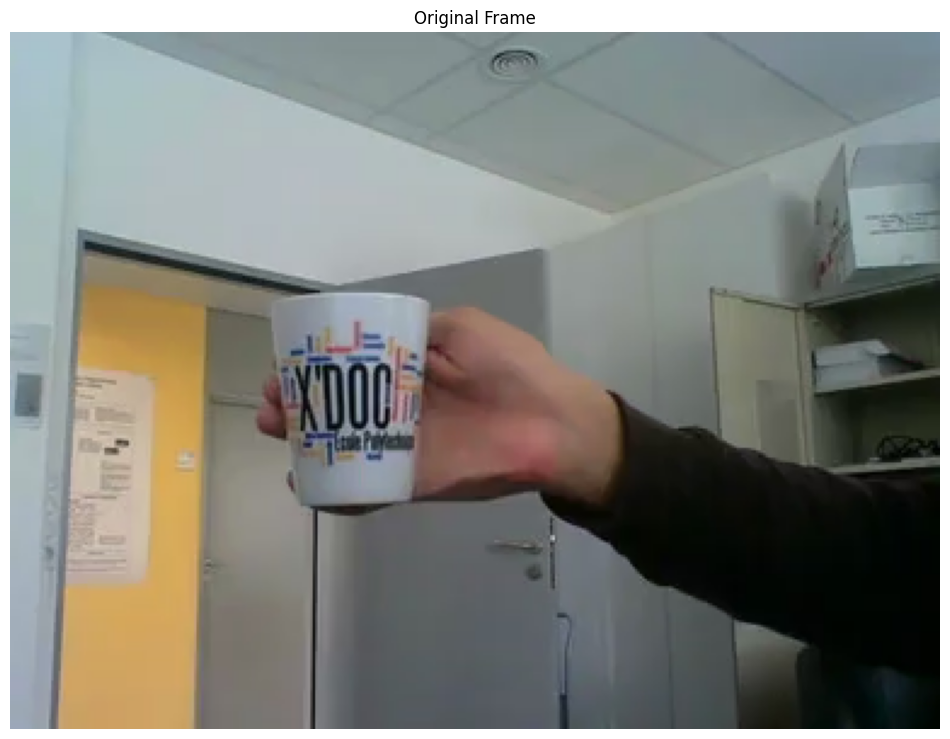

Processing Layer: conv1_2 (Index 2)


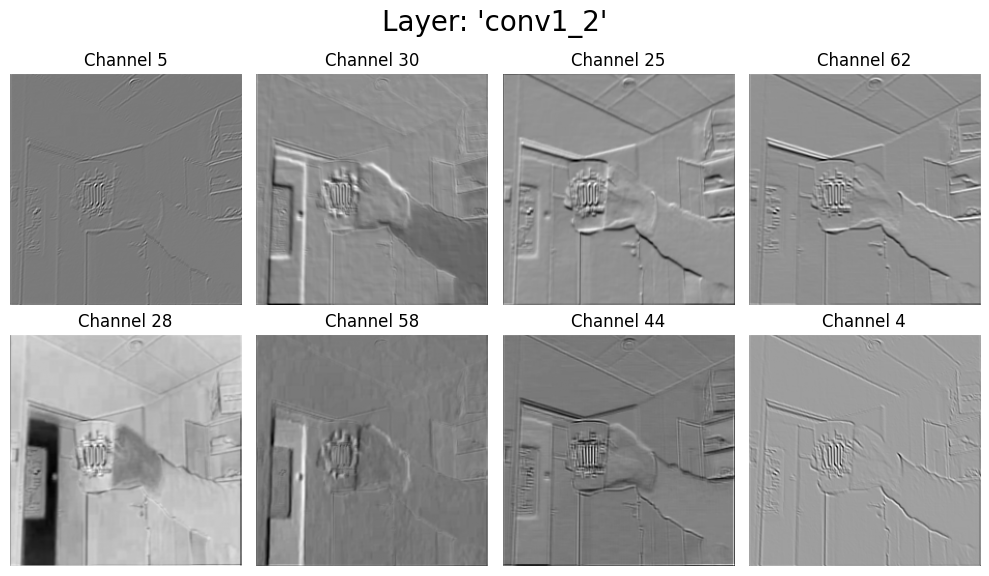

Processing Layer: conv2_2 (Index 7)


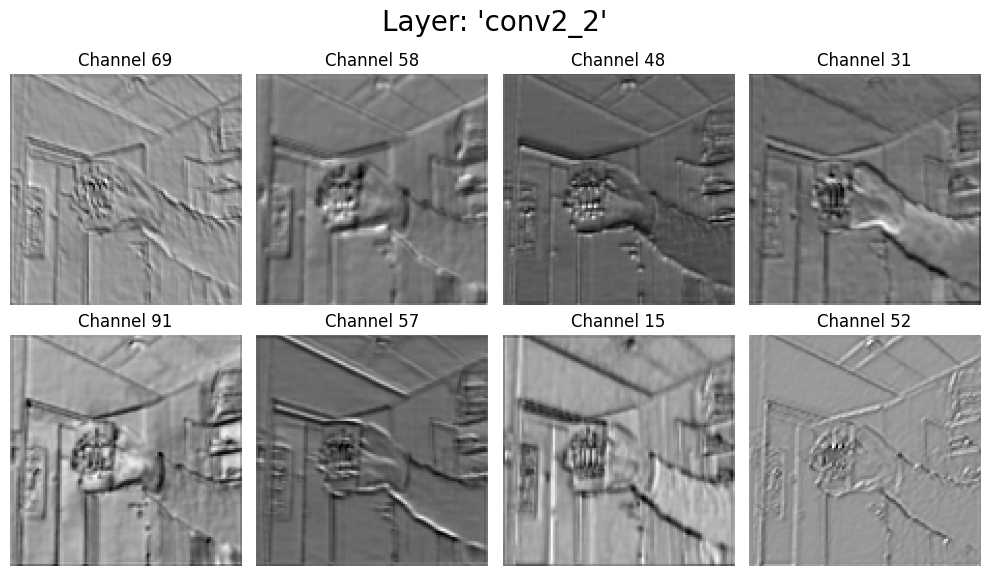

Processing Layer: conv3_2 (Index 12)


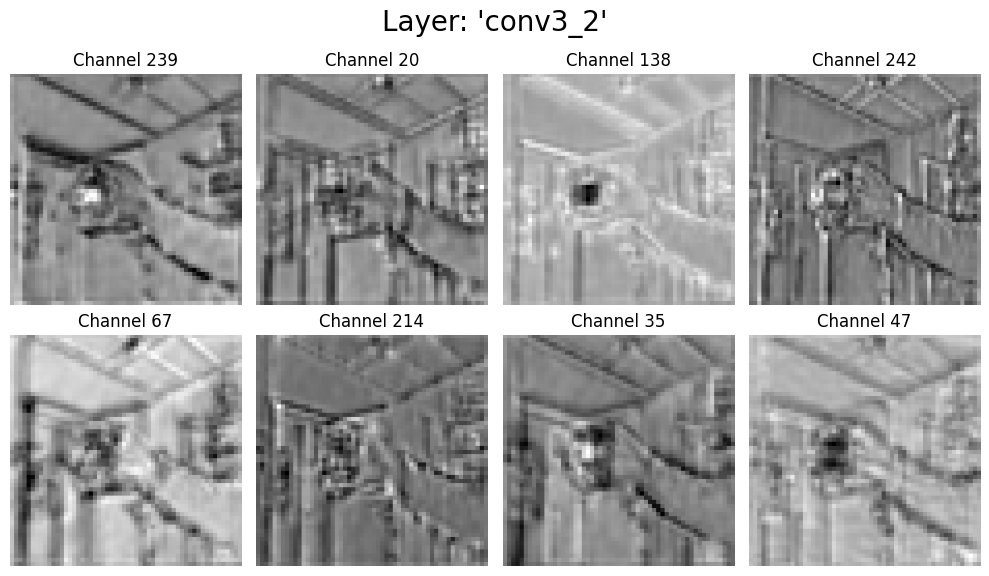

Processing Layer: conv4_2 (Index 19)


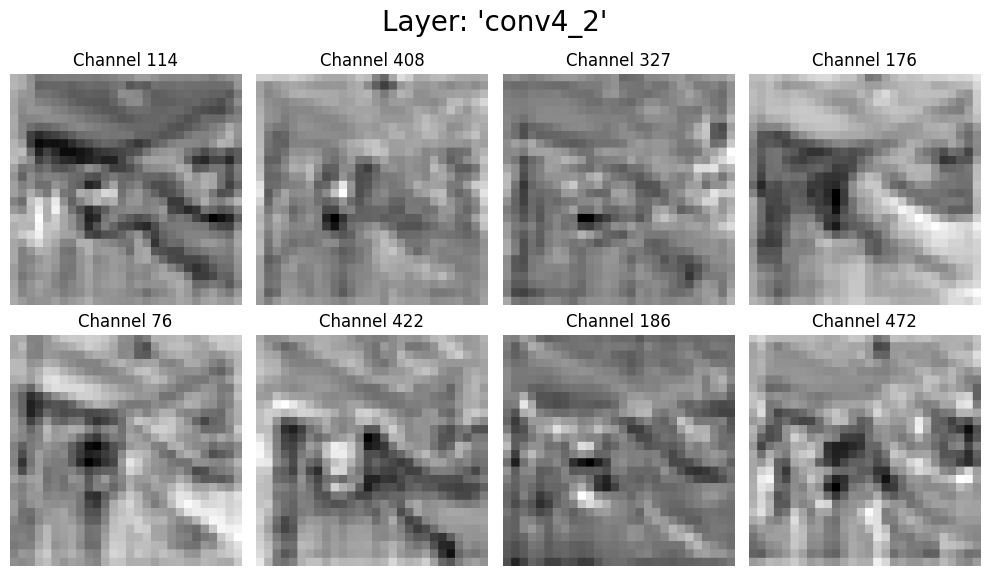

Processing Layer: conv5_2 (Index 26)


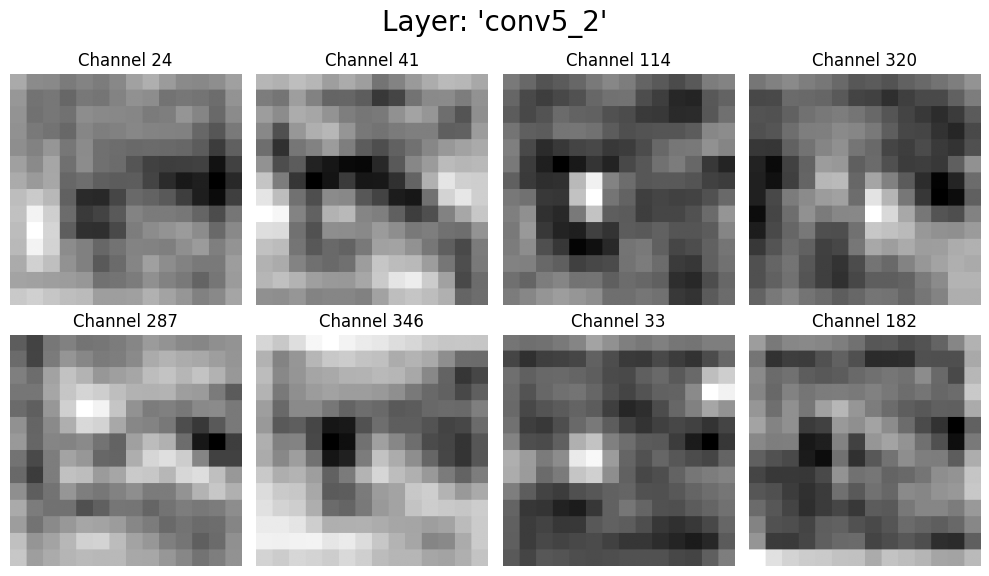

In [ ]:
VIDEO_PATH = 'Sequences/Antoine_Mug.mp4'
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()

prep_frame = preprocess_image(frame)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Original Frame")
plt.axis('off')
plt.show()

for layer_name, layer_index in LAYERS_TO_INSPECT.items():
    print(f"Processing Layer: {layer_name} (Index {layer_index})")

    features = get_features_at_layer(model, layer_index, prep_frame)
    
    plot_channel_grid(features, layer_name)

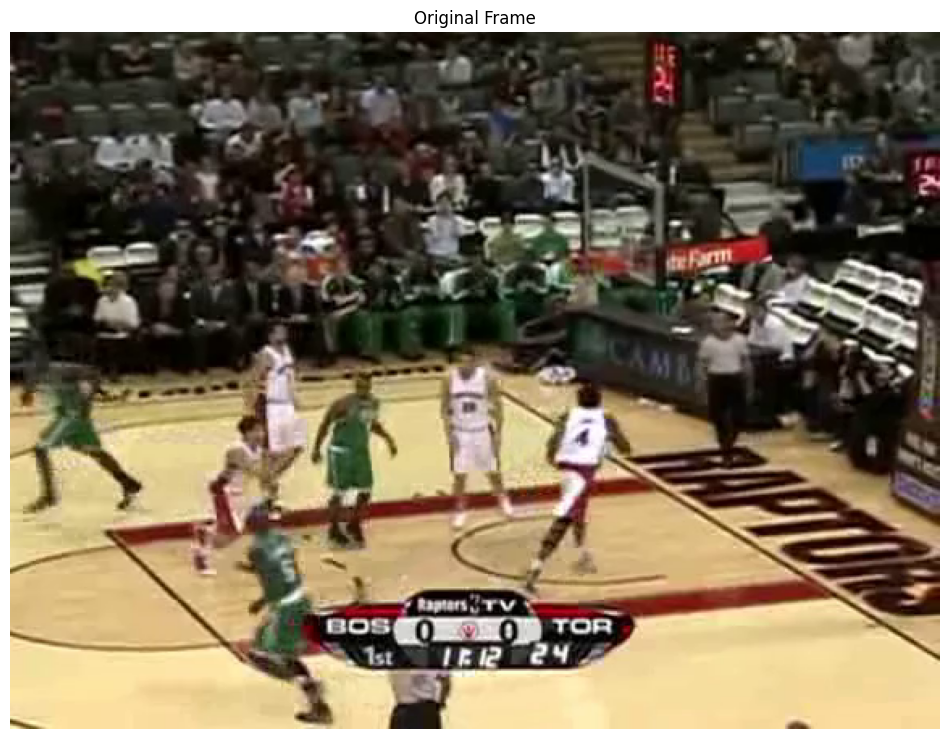

Processing Layer: conv1_2 (Index 2)


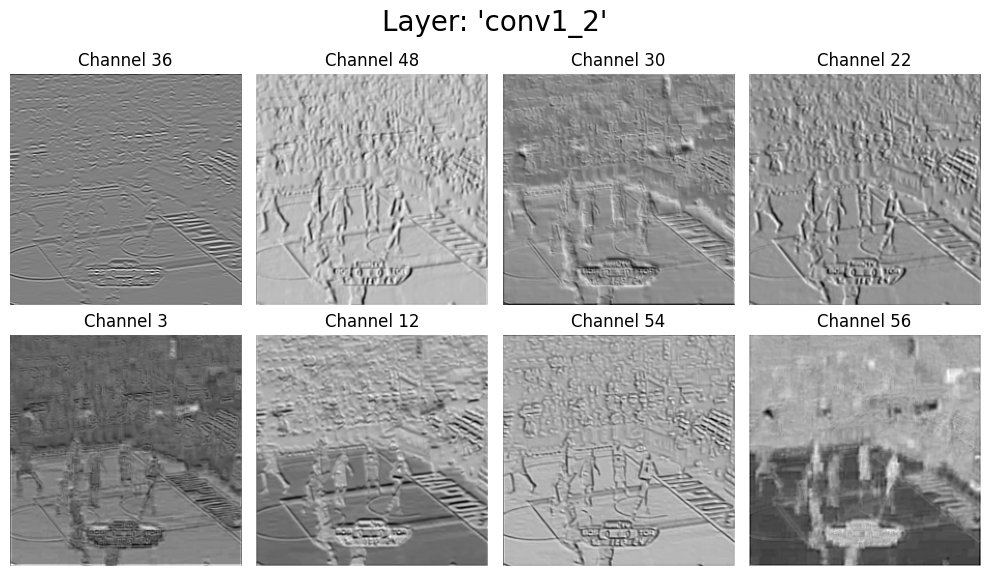

Processing Layer: conv2_2 (Index 7)


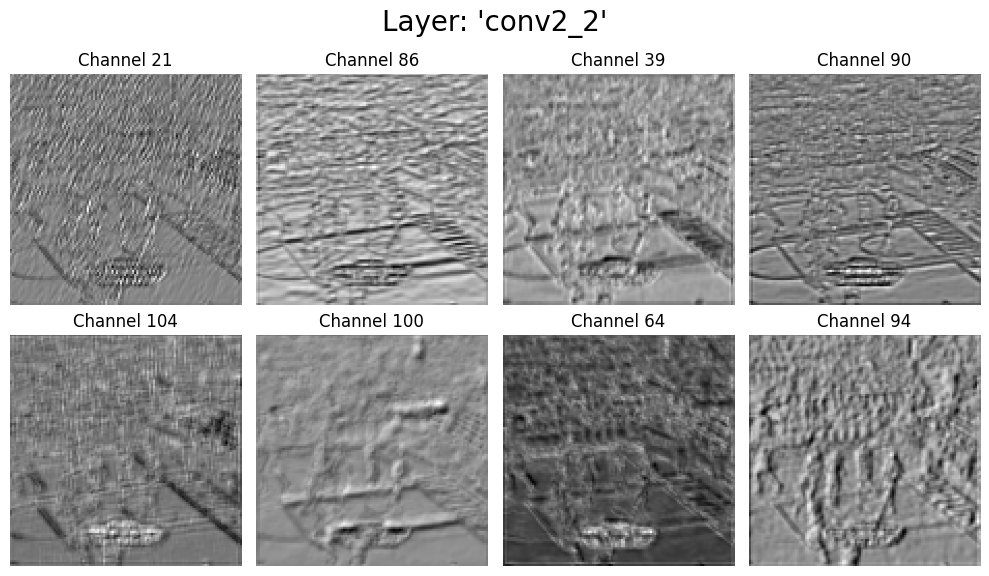

Processing Layer: conv3_2 (Index 12)


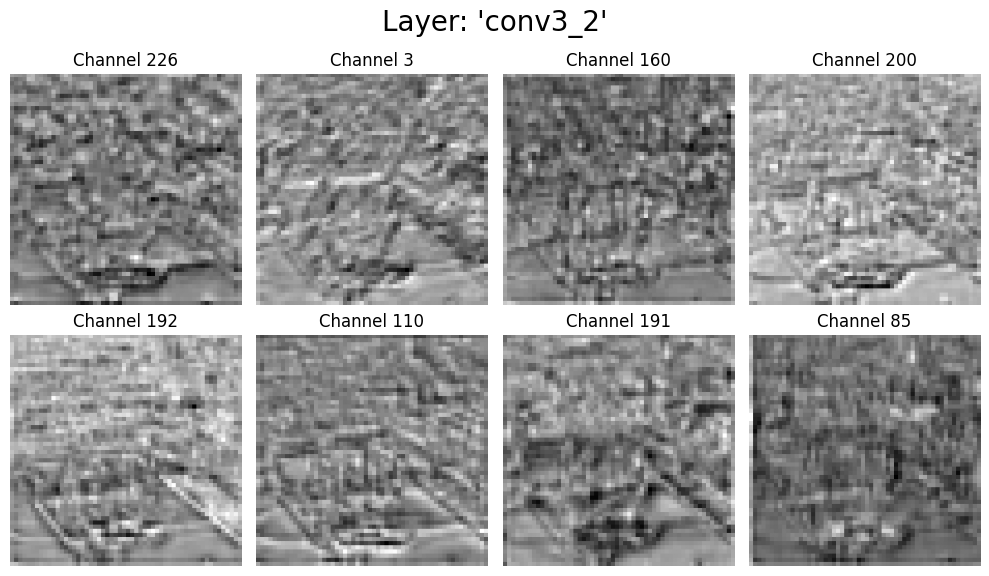

Processing Layer: conv4_2 (Index 19)


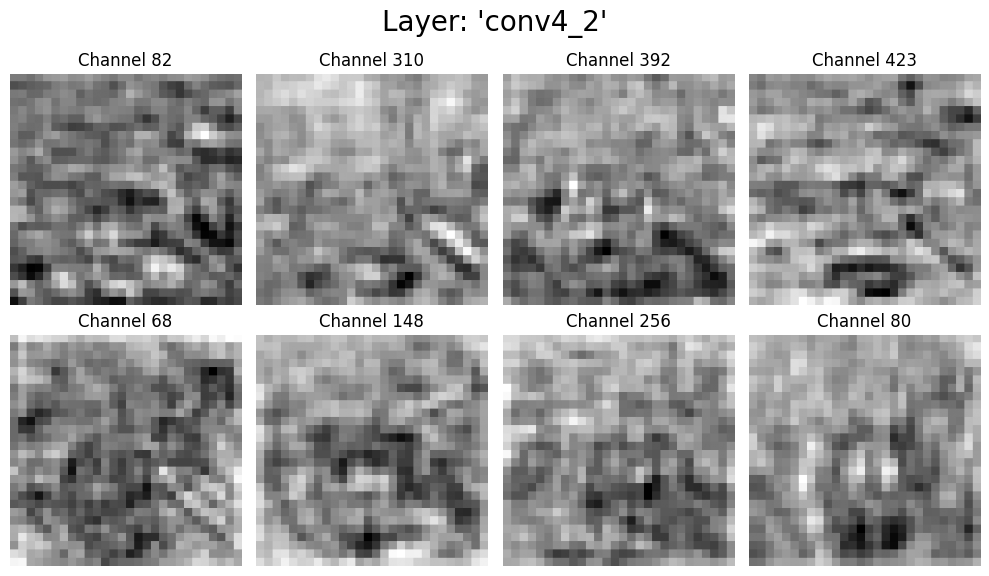

Processing Layer: conv5_2 (Index 26)


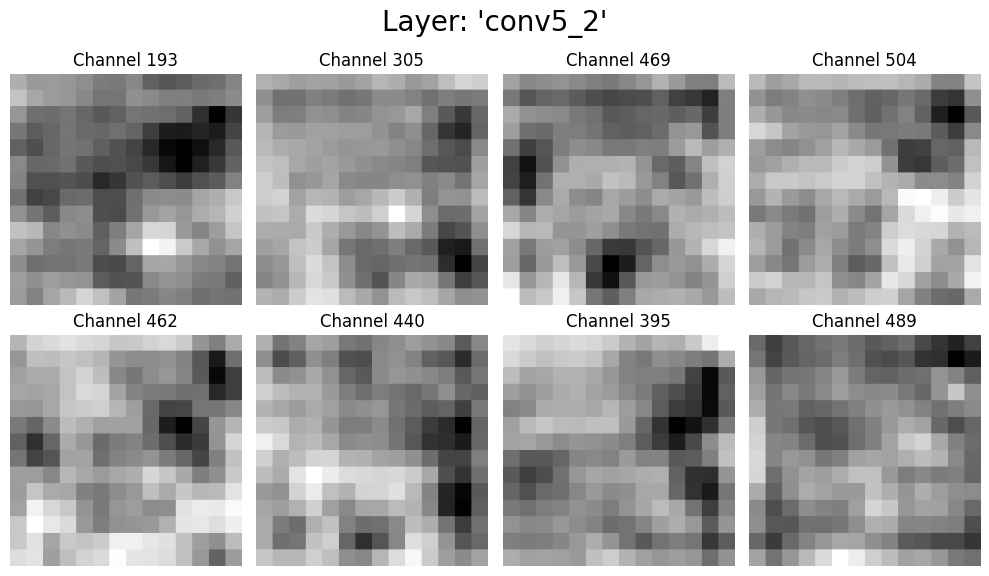

In [ ]:
VIDEO_PATH = 'Sequences/VOT-Basket.mp4'
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()

prep_frame = preprocess_image(frame)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Original Frame")
plt.axis('off')
plt.show()

for layer_name, layer_index in LAYERS_TO_INSPECT.items():
    print(f"Processing Layer: {layer_name} (Index {layer_index})")
    
    features = get_features_at_layer(model, layer_index, prep_frame)
    
    plot_channel_grid(features, layer_name)

## Choosing the best channels

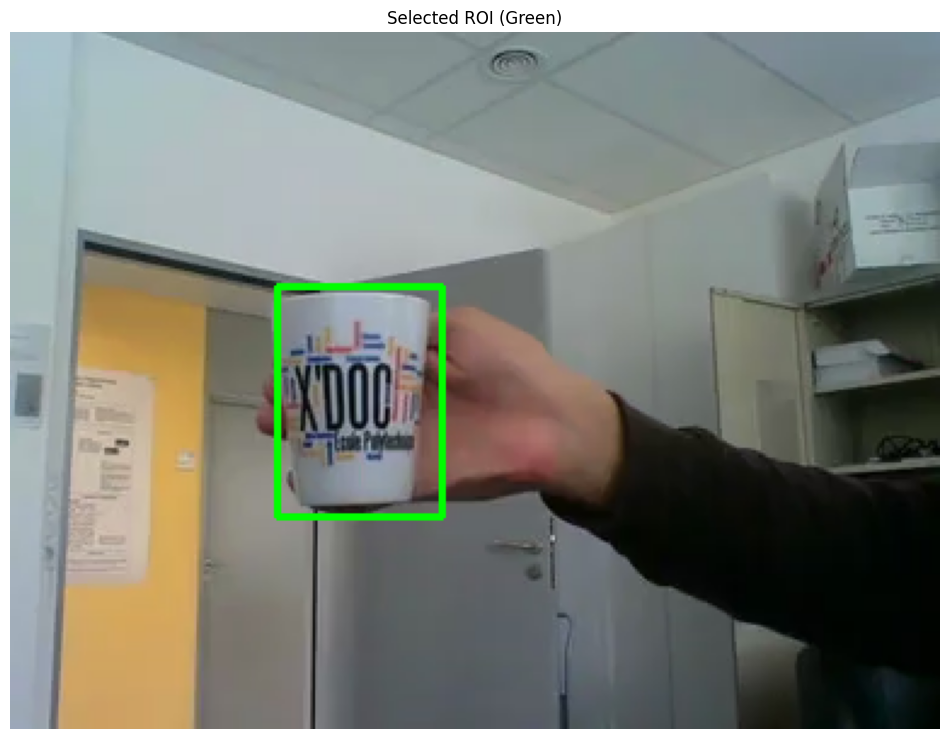

In [ ]:
VIDEO_PATH = 'Sequences/Antoine_Mug.mp4'

# (r=x, c=y, h=width, w=height)
OBJ_COORDS = [110, 105, 68, 95]

LAYER_TO_ANALYZE_INDEX = 19
NUM_CHANNELS_TO_SHOW = 32
FEATURE_SIZE = 28

cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()

frame_with_boxes = frame.copy() 
r, c, h, w = OBJ_COORDS
cv2.rectangle(frame_with_boxes, (r, c), (r+h, c+w), (0, 255, 0), 2) # Green ROI

frame_rgb = cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.title("Selected ROI (Green)")
plt.axis('off')
plt.show()

In [ ]:
def scale_coords_to_feature_map(r, c, h, w, orig_shape):
    orig_h, orig_w = orig_shape[:2]
    scale_x = FEATURE_SIZE / orig_w
    scale_y = FEATURE_SIZE / orig_h
    
    r_feat = int(r * scale_x)
    c_feat = int(c * scale_y)
    h_feat = int(h * scale_x)
    w_feat = int(w * scale_y)
    
    if h_feat == 0: h_feat = 1
    if w_feat == 0: w_feat = 1
    if c_feat + w_feat > FEATURE_SIZE: w_feat = FEATURE_SIZE - c_feat
    if r_feat + h_feat > FEATURE_SIZE: h_feat = FEATURE_SIZE - r_feat
        
    return (r_feat, c_feat, h_feat, w_feat)

In [52]:
prep_frame = preprocess_image(frame)
frame_features = get_features_at_layer(model, LAYER_TO_ANALYZE_INDEX, prep_frame) # [C, H, W]
num_channels_total = frame_features.shape[0]

r_s, c_s, h_s, w_s = scale_coords_to_feature_map(OBJ_COORDS[0], OBJ_COORDS[1], OBJ_COORDS[2], OBJ_COORDS[3], frame.shape)

roi_mask = torch.zeros(FEATURE_SIZE, FEATURE_SIZE)
roi_mask[c_s : c_s+w_s, r_s : r_s+h_s] = 1 
bg_mask = 1 - roi_mask 

scores = []
for i in range(num_channels_total):
    channel_map = frame_features[i]
    activated_map = torch.nn.functional.relu(channel_map)
    
    mean_roi = (activated_map * roi_mask).sum() / (roi_mask.sum() + 1e-6)
    mean_bg = (activated_map * bg_mask).sum() / (bg_mask.sum() + 1e-6)
    
    score = mean_roi - mean_bg
    scores.append( (score.item(), i) ) 


scores.sort(key=lambda x: x[0], reverse=True)
top_k_channels = scores[:NUM_CHANNELS_TO_SHOW]

print(f"--- Top {NUM_CHANNELS_TO_SHOW} 'Golden' Channels ---")
for score, idx in top_k_channels:
    print(f"Channel {idx:3}: Score = {score:5.2f}")

--- Top 32 'Golden' Channels ---
Channel 266: Score =  7.71
Channel 463: Score =  7.13
Channel   2: Score =  6.92
Channel 244: Score =  6.70
Channel 482: Score =  6.69
Channel 341: Score =  6.31
Channel 297: Score =  6.24
Channel 456: Score =  6.18
Channel 180: Score =  5.86
Channel  67: Score =  5.49
Channel 315: Score =  4.98
Channel 286: Score =  4.86
Channel 145: Score =  4.84
Channel 447: Score =  4.84
Channel 285: Score =  4.83
Channel 289: Score =  4.81
Channel 147: Score =  4.60
Channel 140: Score =  4.45
Channel 150: Score =  4.32
Channel 243: Score =  4.25
Channel 435: Score =  4.09
Channel 441: Score =  4.03
Channel 480: Score =  4.02
Channel  11: Score =  3.90
Channel 154: Score =  3.74
Channel 507: Score =  3.66
Channel 165: Score =  3.60
Channel 403: Score =  3.55
Channel 206: Score =  3.52
Channel 224: Score =  3.52
Channel 186: Score =  3.35
Channel 143: Score =  3.34


Visualizing the top channels...


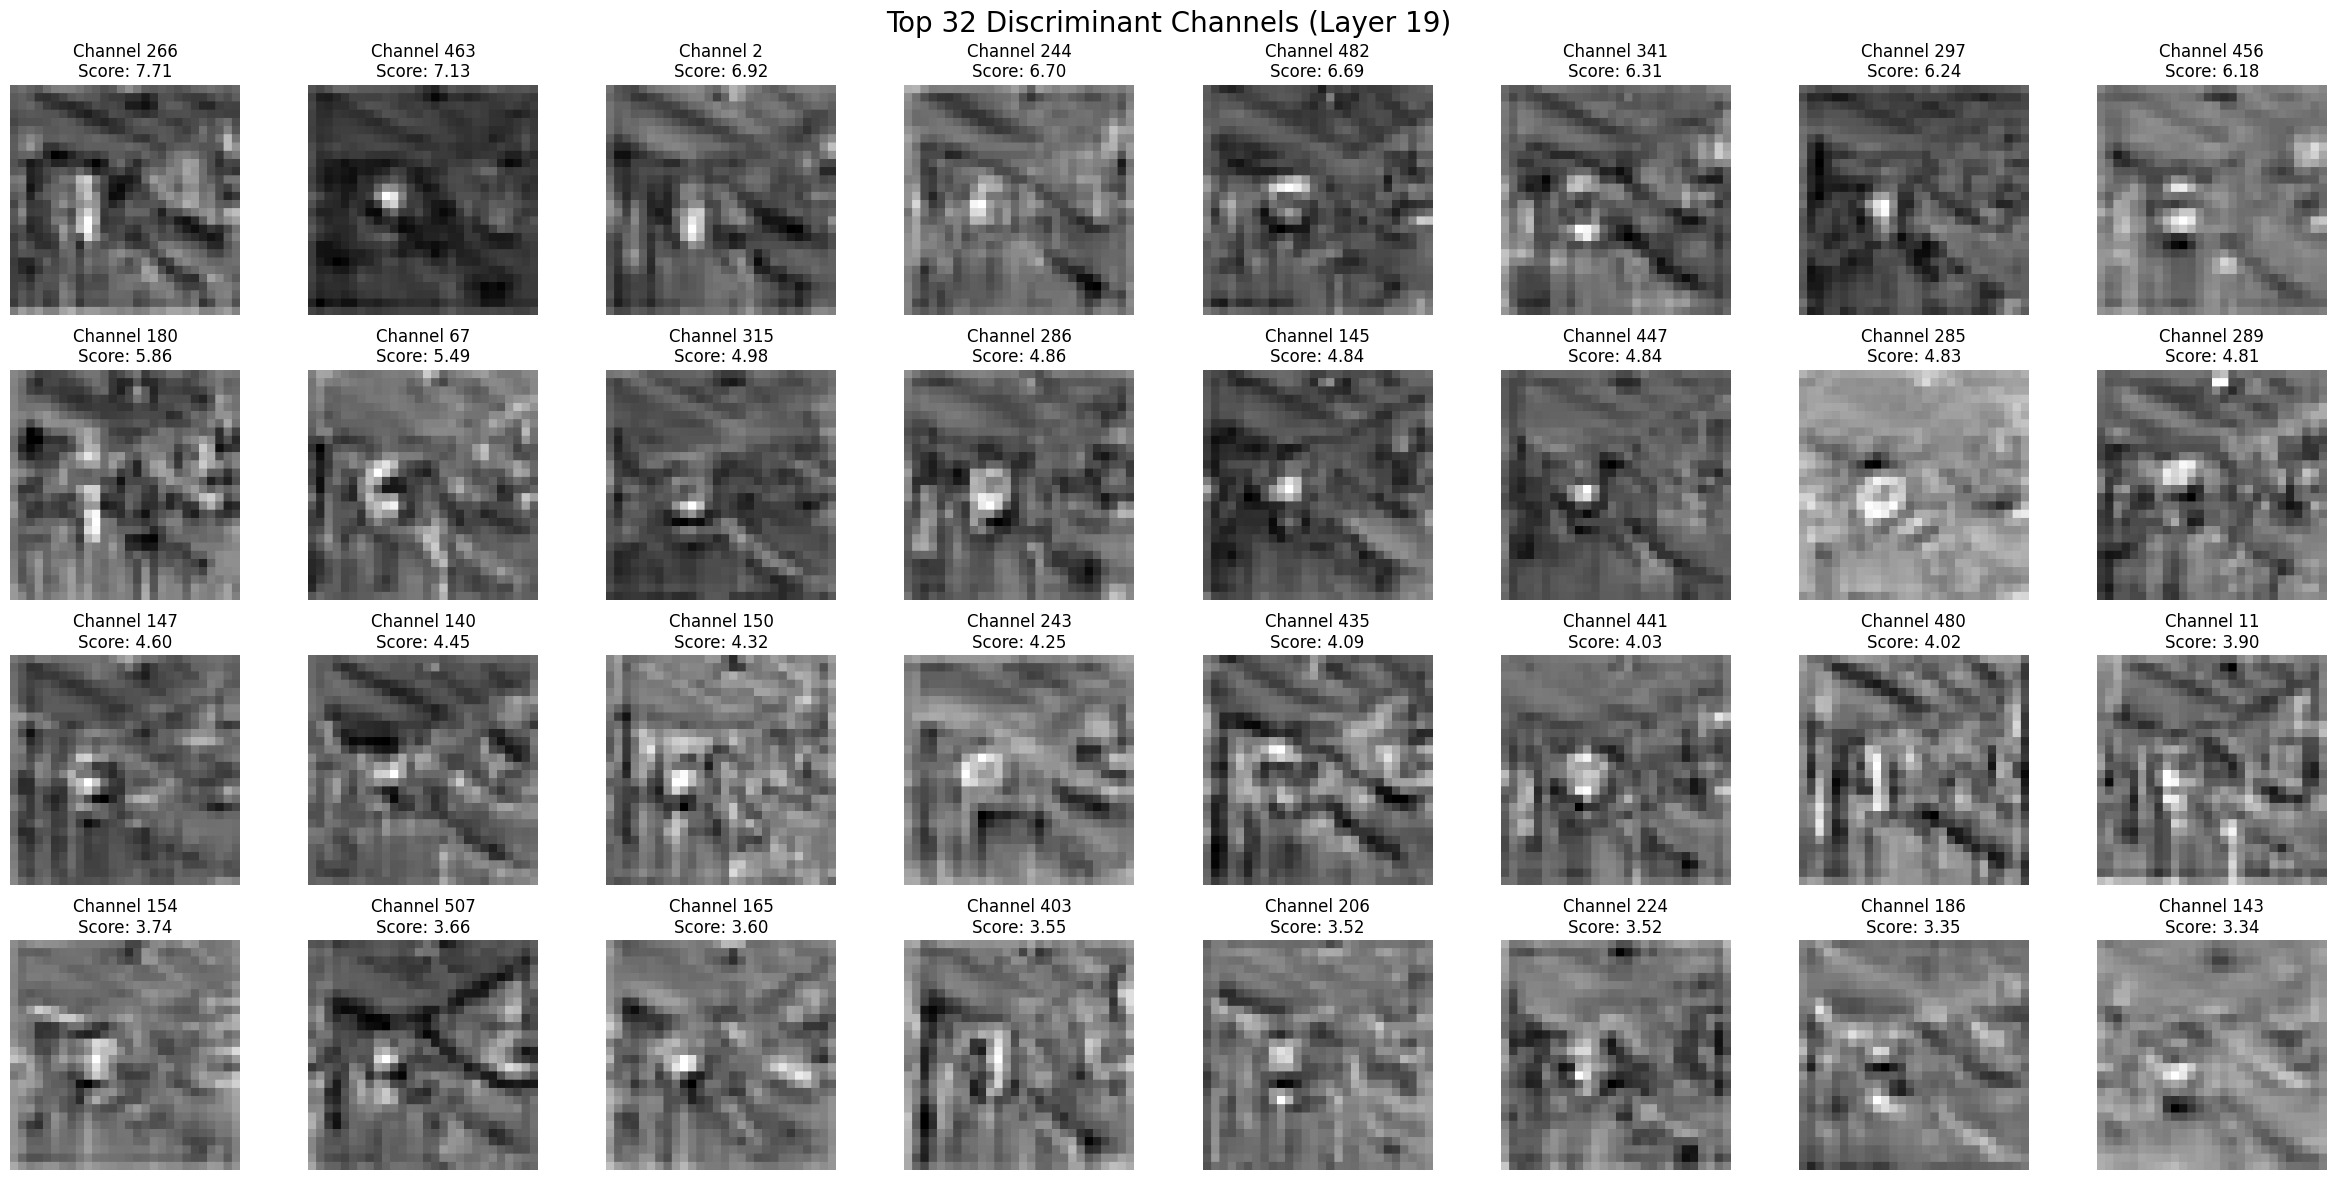

In [51]:
print("Visualizing the top channels...")

# 4x8 grid for 32 images
fig, axes = plt.subplots(4, 8, figsize=(24, 12))

for i, (score, channel_idx) in enumerate(top_k_channels):
    channel_map = frame_features[channel_idx].numpy()
    norm_map = cv2.normalize(channel_map, None, 0, 1, cv2.NORM_MINMAX)
    large_map = cv2.resize(norm_map, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    row = i // 8
    col = i % 8
    
    ax = axes[row, col]
    ax.imshow(large_map, cmap='gray')
    ax.set_title(f"Channel {channel_idx}\nScore: {score:.2f}")
    ax.axis('off')

plt.suptitle(f"Top {NUM_CHANNELS_TO_SHOW} Discriminant Channels (Layer {LAYER_TO_ANALYZE_INDEX})", fontsize=20)
plt.tight_layout()
plt.show()